# Sprite Generator $5 Model - Part 2

Testing more setups and experiments with the simple $5 model (takes in as input a text embedding to output a 8x8 PICO-8 sprite)

---

### Imports and Configurations

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# tensorflow
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Conv2DTranspose, Flatten, Layer, Reshape, Input, LeakyReLU, MaxPooling2D, Concatenate, Conv1D, Lambda, BatchNormalization, UpSampling2D, Add
from tensorflow.keras.models import Model


%matplotlib inline

/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-01 11:53:49.804207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#import from Python folder to get the utils
import sys
sys.path.append('../Python')
from utils import picoSS2np, showMultiSprPalette, showMultiSprRGB, showSprRGB, showSprPalette, animatePal, encodeSpr1H, decodeSpr1H, showTxtEmb

In [5]:
### CONSTANT VARIABLES   ###

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


Food Dataset shape: (100, 8, 8)
Char Dataset shape: (100, 8, 8)


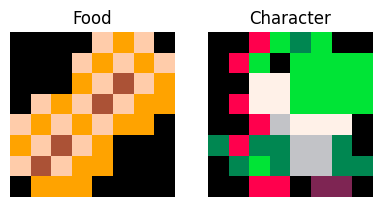

In [6]:
# import from the PICO sprites posted onto Twitter 
# Food: https://twitter.com/JUSTIN_CYR/status/634546317713391616
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_food_dat = np.load('../data/rip_data/pico_food.npy',allow_pickle=True)
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)

print(f"Food Dataset shape: {pico_food_dat.shape}")
print(f"Char Dataset shape: {pico_char_dat.shape}")

# show a random food and character sprite 
rand_food = random.choice(pico_food_dat)
rand_char = random.choice(pico_char_dat)
showMultiSprPalette([rand_food,rand_char],textArr=['Food','Character'])

In [7]:
# import sentence-transformer for text embedding 
SBERT_MODEL = SentenceTransformer('bert-base-nli-mean-tokens')

def sentEmb(txt):
    return SBERT_MODEL.encode([txt])[0]

# import the text data
pico_char_labels = np.array([l.strip() for l in open('../data/rip_data/character_desc.txt','r').readlines()])

# encode the labels
pico_char_emb = []
with tqdm(total=len(pico_char_labels)) as pbar:
    pbar.set_description("Encoding labels")
    for l in pico_char_labels:
        pico_char_emb.append(sentEmb(l))
        pbar.update(1)

pico_char_emb = np.array(pico_char_emb)

Encoding labels: 100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


Character: an old white duck with a black top hat, blue outfit, and a brown cane


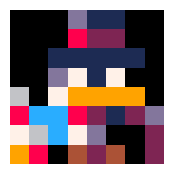

Encoding length: 768


In [8]:
# show a random character and its description
rand_char_idx = random.randint(0,len(pico_char_labels))
print(f"Character: {pico_char_labels[rand_char_idx]}")
showSprPalette(pico_char_dat[rand_char_idx])

desc_enc = pico_char_emb[rand_char_idx]
print(f"Encoding length: {len(desc_enc)}")

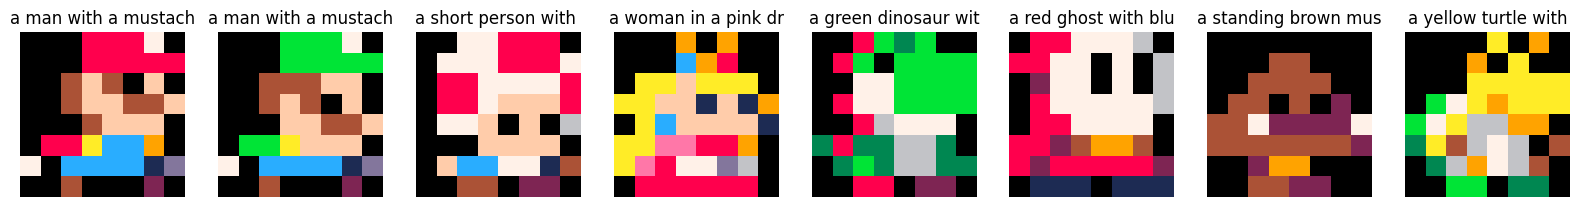

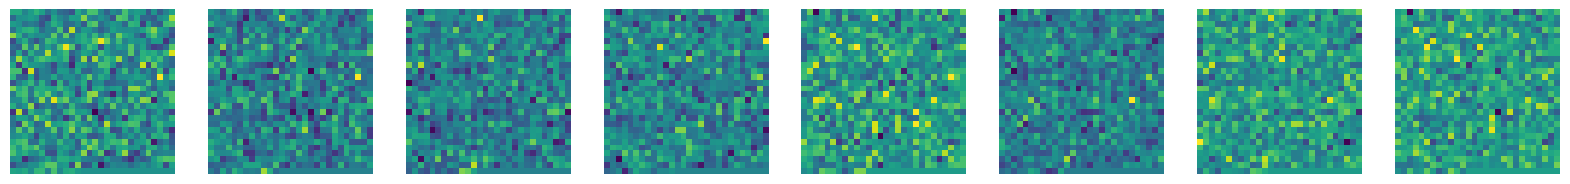

In [9]:
# show the text embedding	
showMultiSprPalette(pico_char_dat[:8],textArr=[l[:20] for l in pico_char_labels[:8]])
showTxtEmb(pico_char_emb[:8])

In [10]:
###   CONFIUGURATIONS   ###

EXPERIMENT = "mult_noise"

GEN_CONF = {
    "EPOCHS" : 20,
    "BATCH_SIZE" : 16,
    "LEARNING_RATE" : 0.001,
    "WINDOW" : 8,
    "REAL_TEST_INDEX": [0,7,30,53,86,90,96,99]
}

CONFIGS = {
    "base": {
        "model_test": ['milk', 'tim'],
        "train_model": False,
        "save_model": False,
        "model_path": f"../models/gen_models/dollars/part2/sprite_fdm2-#-{GEN_CONF['EPOCHS']}e_base.h5"
    },
    "clip": {
        "model_test": ['milk', 'tim'],
        "train_model": False,
        "save_model": False,
        "model_path": f"../models/gen_models/dollars/part2/sprite_fdm2-#-{GEN_CONF['EPOCHS']}e_clip.h5"
    },
    "add_noise" : {
        "model_test": ['milk', 'tim'],
        "train_model": True,
        "num_noise" : 10,
        "noise_mu": 0,
        "noise_std": 0.05,
        "save_model": True,
        "model_path": f"../models/gen_models/dollars/part2/sprite_fdm2-#-{GEN_CONF['EPOCHS']}e_addnoise.h5"
    },
    "mult_noise" : {
        "model_test": ['milk', 'tim'],
        "train_model": True,
        "num_noise" : 10,
        "noise_mu": 1,
        "noise_std": 0.05,
        "save_model": True,
        "model_path": f"../models/gen_models/dollars/part2/sprite_fdm2-#-{GEN_CONF['EPOCHS']}e_multnoise.h5"
    }
}

### General Setup

In [11]:
# create the training dataset (embheddings -> images)
pico_char_emb = SBERT_MODEL.encode(pico_char_labels)
pico_char_emb = np.array(pico_char_emb)

X_train = pico_char_emb
Y_train = np.array([encodeSpr1H(s) for s in pico_char_dat])

print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")

X_train: (100, 768)
Y_train: (100, 8, 8, 16)


In [12]:
# named after Tim's bet that this model was too simple lol
class FiveDollarModel(Model):
    def __init__(self,lv_shape,model_version='milk',embedder=SBERT_MODEL, lr=0.0001, channels=16):
        super(FiveDollarModel, self).__init__()
        self.embedder = embedder
        self.lr = lr
        self.channels = channels

        # for tim's model
        self.init = tf.keras.initializers.HeNormal(seed=32)

        # Milk's version of the $5 model - super small and simple ~ 200k params
        if model_version == 'milk':
            self.decoder = Sequential([
                InputLayer(input_shape=(lv_shape,)),
                # Dense(512,activation='relu'),
                Dense(256,activation='relu'),
                Reshape((2,2,64)),
                Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', activation='relu'),
                Conv2DTranspose(16, (2,2), strides=(2,2), padding='same', activation='softmax')     # should output to a 8x8x16 one-hot encoded image
            ])

        # Tim's version of the $5 model - slightly larger and more complex ~ 1.5M params
        elif model_version == 'tim':
            embedding = Input(shape=(lv_shape,))
            x = Dense(128 * 2 * 2, activation="relu", kernel_initializer=self.init)(embedding)
            x = Reshape((2, 2, 128))(x)

            # upsample to 4x4x16
            x = UpSampling2D()(x)
            x1 = Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x)
            x1 = BatchNormalization()(x1)
            x1 = Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x1)
            x1 = BatchNormalization()(x1)
            x = Add()([x, x1])

            x1 = Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x)
            x1 = BatchNormalization()(x1)
            x1 = Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x1)
            x1 = BatchNormalization()(x1)
            x = Add()([x, x1])

            # upsample to 8x8x16
            x = UpSampling2D()(x)
            x2 = Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x)
            x2 = BatchNormalization()(x2)
            x2 = Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x2)
            x2 = BatchNormalization()(x2)
            x = Add()([x, x2])

            # final image output
            img = Conv2D(self.channels, kernel_size=3, padding="same", activation="softmax", kernel_initializer=self.init)(x)

            self.decoder = Model(embedding, img, name='decoder')

        self.decoder.compile(optimizer=optimizers.Adam(self.lr), loss='categorical_crossentropy', metrics=['accuracy'])
        self.decoder.summary()
        

    # embeds the text and returns an image
    def txt2img(self,txt,uncode=True):
        emb = self.embedder.encode([txt])
        img = self.decoder.predict(np.array(emb),verbose=False)[0]
        if uncode:
            return decodeSpr1H(img)
        else:
            return img
        
    # returns an image from the embedding
    def emb2img(self,emb,uncode=True):
        img = self.decoder.predict(np.array([emb]),verbose=False)[0]
        if uncode:
            return decodeSpr1H(img)
        else:
            return img
        
    # import a model from a path
    def importModel(self,model_path):
        self.decoder = tf.keras.models.load_model(model_path)
        self.decoder.summary()
        self.decoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr),metrics=['accuracy'],loss='categorical_crossentropy')


    # export the model to a path
    def exportModel(self,model_path):
        self.decoder.save(model_path,save_format='h5')

In [13]:
# give test images for the model to generate
def testModel(model,txts,embs=None,title='',showEmb=True):
    imgs = []
    for i in range(len(txts)):
        if embs is not None:
            img = model.emb2img(embs[i])
        else:
            img = model.txt2img(txts[i])
        imgs.append(img)
    showMultiSprPalette(imgs,text=title,textArr=[t[:20] for t in txts])
    if showEmb and embs is not None:
        showTxtEmb(embs)

# real texts to test the model on
mod_test_set = {
    'real': {'text':['Mario','Koopa','Leonardo','Finn','Dewey','Link','Samus','Pikachu'], 'emb':pico_char_emb[GEN_CONF['REAL_TEST_INDEX']]},
    'fake': {'text':["a blue turtle standing up", "a woman with green hair", "a duck with a yellow shirt", "a man with a red hat", "a man with a purple bandana", "a dog with sunglasses", "a girl with an orange outfit", "a yellow monkey with green cheeks"]}
}
mod_test_set['fake']['emb'] = np.array(SBERT_MODEL.encode(mod_test_set['fake']['text']))

### Experiment 0 - Base Comparison

NOTES
- Milk model requires much more training (100 epochs) to reach > 90% accuracy - Tim model reaches 100% within 50 epochs
- 50 epoch Tim model has perfect reconstruction and relatively generation on fake data


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               196864    
                                                                 
 reshape_23 (Reshape)        (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 4, 4, 32)         8224      
 Transpose)                                                      
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 8, 8, 16)         2064      
 Transpose)                                                      
                                                                 
Total params: 207,152
Trainable params: 207,152
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
______________________________

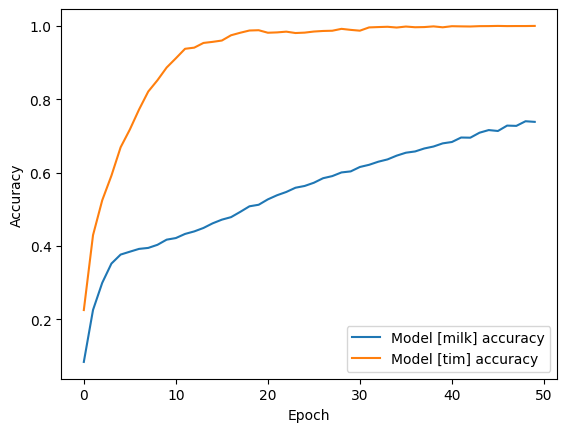

In [82]:
if EXPERIMENT == "base":
    # make the models
    model_set = {}
    for m in CONFIGS["base"]["model_test"]:
        model_set[m] = (FiveDollarModel(lv_shape=768,model_version=m,lr=GEN_CONF["LEARNING_RATE"]))
    
    # train the models or import them
    for k,m in model_set.items():
        mod_path = CONFIGS["base"]["model_path"].replace("#",k)

        # train from scratch
        if CONFIGS["base"]["train_model"]:
            print(f"Training model {k}")
            acc = m.decoder.fit(X_train,Y_train,epochs=GEN_CONF["EPOCHS"],batch_size=GEN_CONF["BATCH_SIZE"], shuffle=True)

            # plot the accuracy
            plt.plot(acc.history['accuracy'], label=f'Model [{k}] accuracy') 

            # export the model
            if CONFIGS["base"]["save_model"]:
                print(f"Saving model {k} to {mod_path}")
                m.exportModel(mod_path)

        # import the models
        else:
            print(f"Skipping training for model {k} and loading from {mod_path}")
            m.importModel(mod_path)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title("Base Experiment Model Accuracy")
    plt.show()

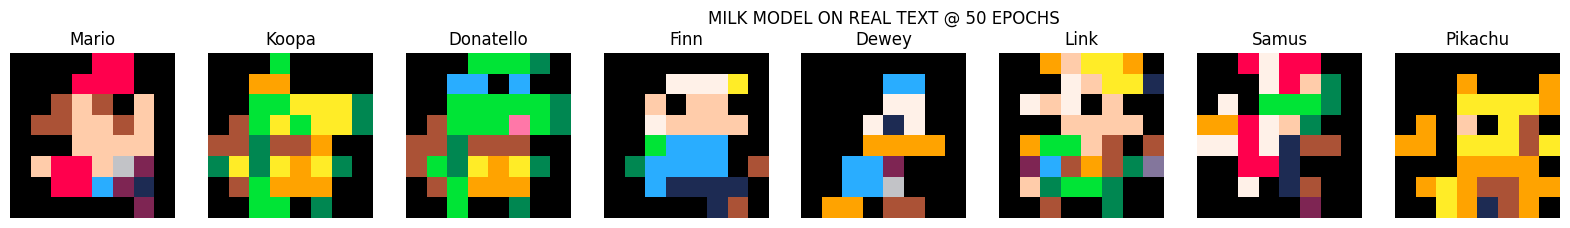

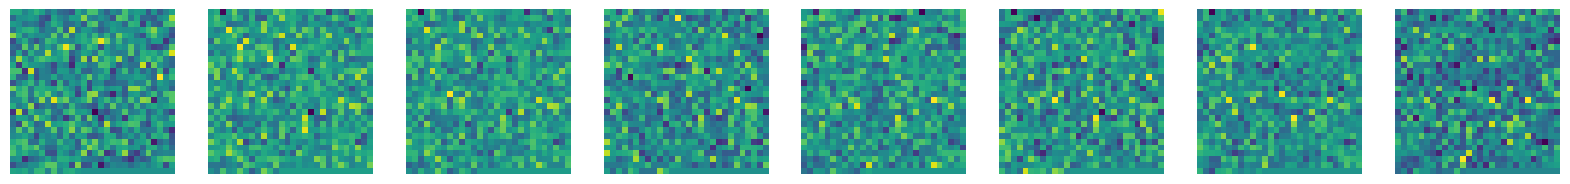

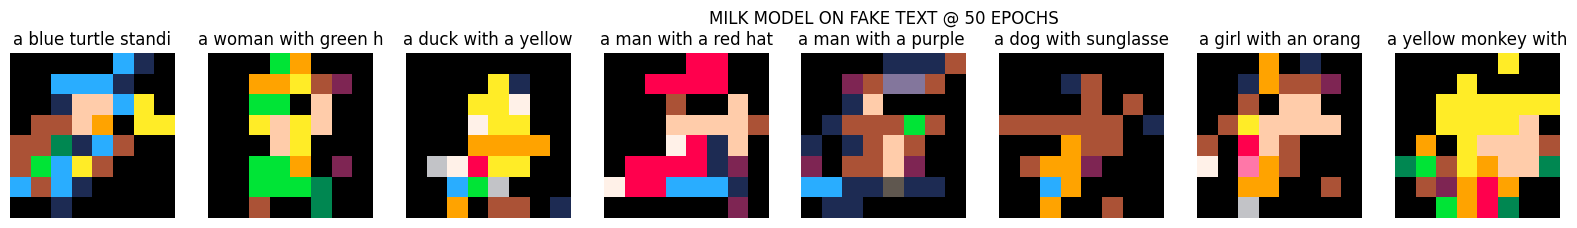

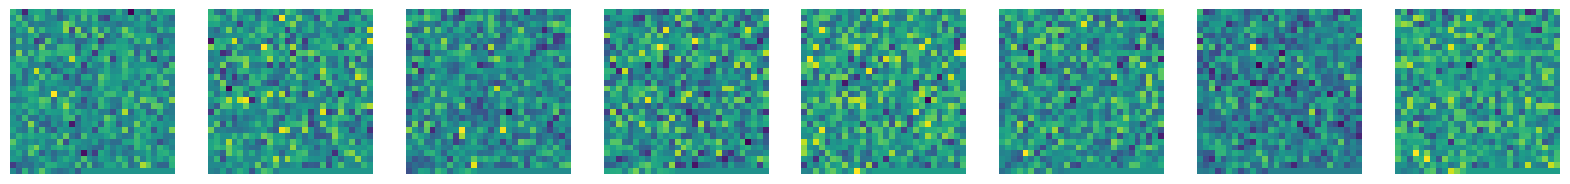

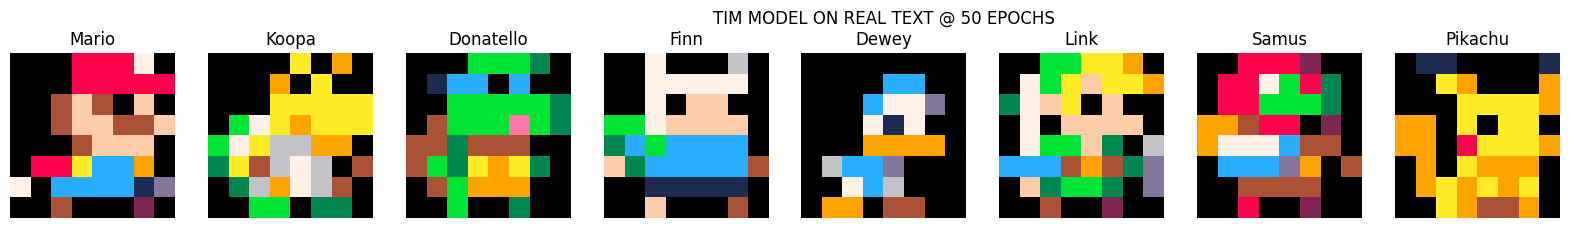

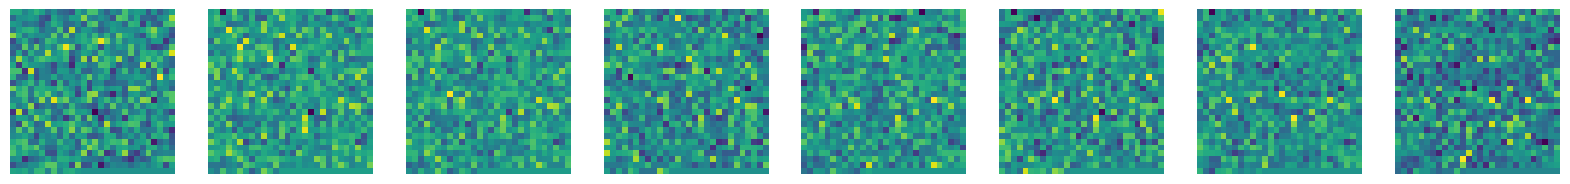

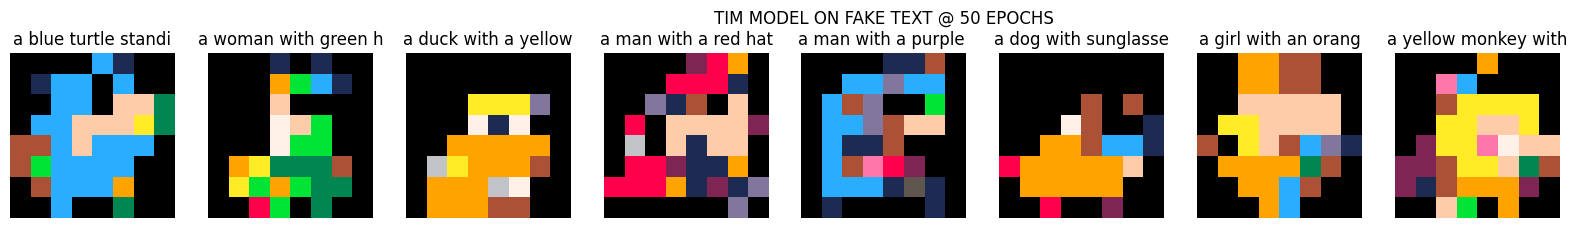

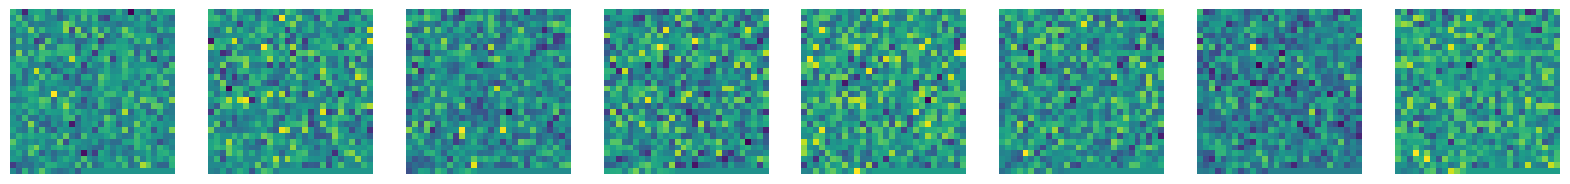

In [83]:
# see output with the embedding below
if EXPERIMENT == "base":
    for k,m in model_set.items():
        for t in ['real', 'fake']:
            testModel(m, mod_test_set[t]['text'], mod_test_set[t]['emb'], title=f"{k} model on {t} text @ {GEN_CONF['EPOCHS']} epochs", showEmb=True)

### Experiment 1 - Clipping Text Embedding space

NOTES
- Milk model needs evem more epochs to train
- Fake output looks more silhoette-ish on both models - but not much better than the base model inputs


In [95]:
# new training + test data - clipped text embeddings
if EXPERIMENT == "clip":
    pico_char_emb_clip = np.clip(pico_char_emb,0,1)
    X_train_clip = pico_char_emb_clip

    # real texts to test the model on
    clip_mod_test_set = {
        'real': {'text':mod_test_set['real']['text'][:], 'emb':np.clip(pico_char_emb[GEN_CONF['REAL_TEST_INDEX']],0,1)},
        'fake': {'text':mod_test_set['fake']['text'][:]}
    }
    clip_mod_test_set['fake']['emb'] = np.clip(np.array(SBERT_MODEL.encode(clip_mod_test_set['fake']['text'])),0,1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 256)               196864    
                                                                 
 reshape_25 (Reshape)        (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_26 (Conv2D  (None, 4, 4, 32)         8224      
 Transpose)                                                      
                                                                 
 conv2d_transpose_27 (Conv2D  (None, 8, 8, 16)         2064      
 Transpose)                                                      
                                                                 
Total params: 207,152
Trainable params: 207,152
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
______________________________

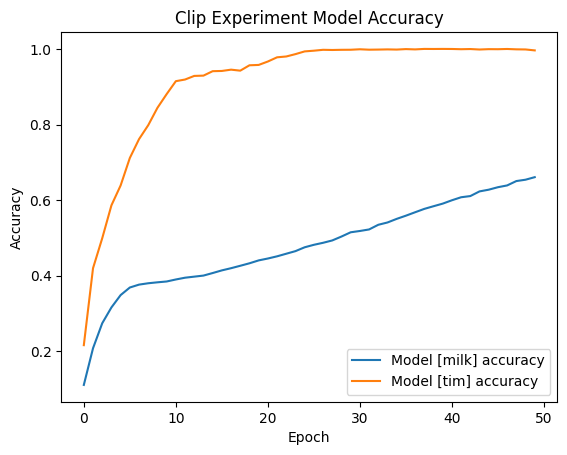

In [90]:
if EXPERIMENT == "clip":
    # make the models
    clip_model_set = {}
    for m in CONFIGS["clip"]["model_test"]:
        clip_model_set[m] = (FiveDollarModel(lv_shape=768,model_version=m,lr=GEN_CONF["LEARNING_RATE"]))
    
    # train the models or import them
    for k,m in clip_model_set.items():
        mod_path = CONFIGS["clip"]["model_path"].replace("#",k)

        # train from scratch
        if CONFIGS["clip"]["train_model"]:
            print(f"Training model {k}")
            acc = m.decoder.fit(X_train_clip,Y_train,epochs=GEN_CONF["EPOCHS"],batch_size=GEN_CONF["BATCH_SIZE"], shuffle=True)

            # plot the accuracy
            plt.plot(acc.history['accuracy'], label=f'Model [{k}] accuracy') 

            # export the model
            if CONFIGS["clip"]["save_model"]:
                print(f"Saving model {k} to {mod_path}")
                m.exportModel(mod_path)

        # import the models
        else:
            print(f"Skipping training for model {k} and loading from {mod_path}")
            m.importModel(mod_path)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title("Clip Experiment Model Accuracy")
    plt.show()

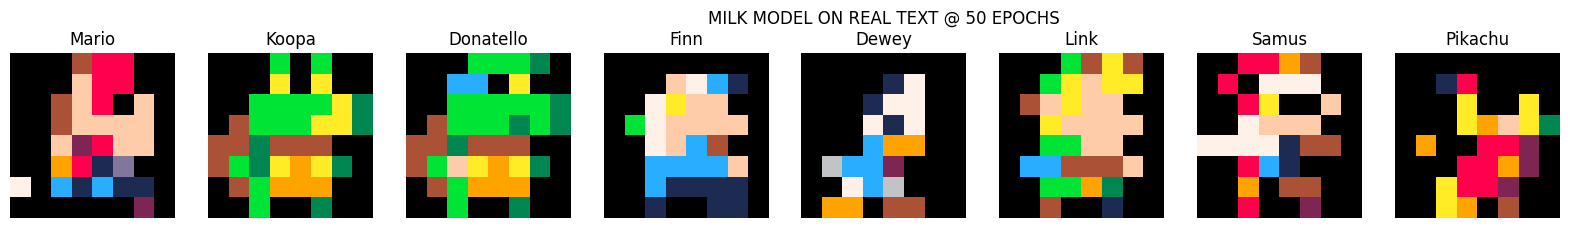

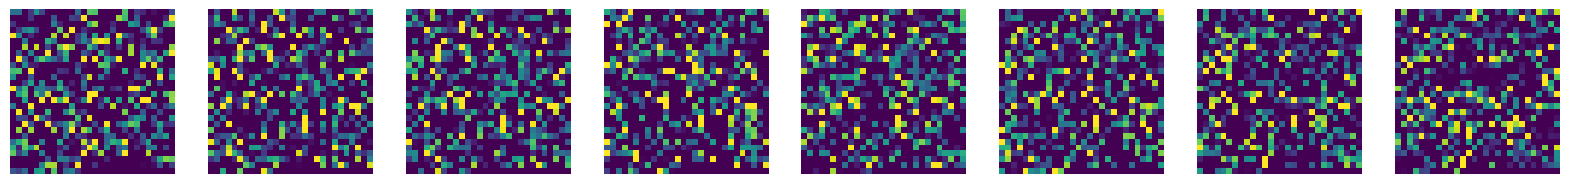

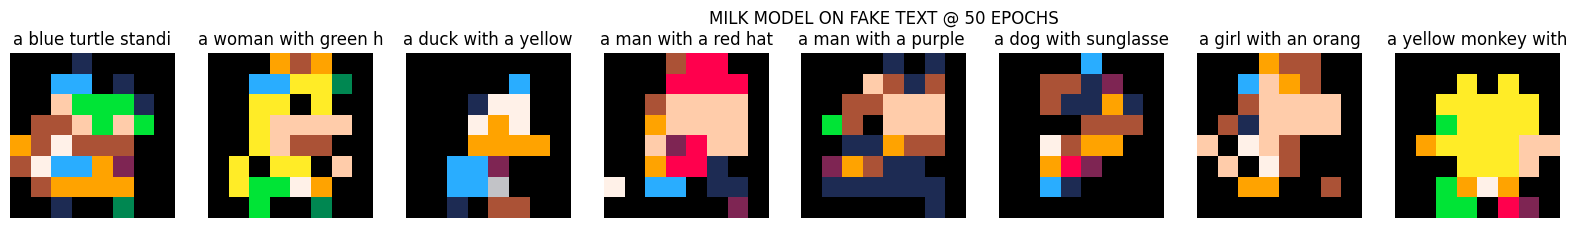

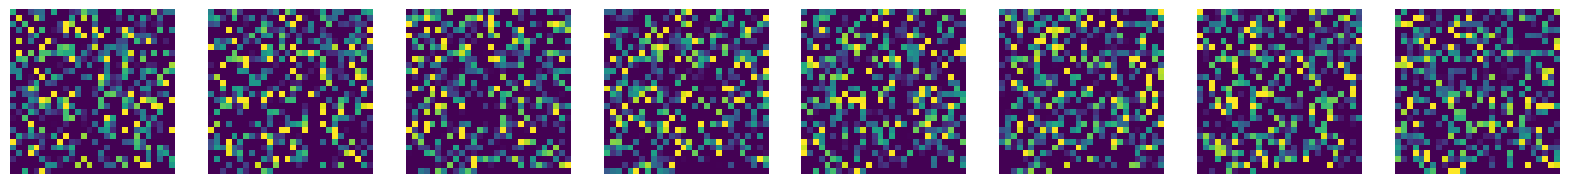

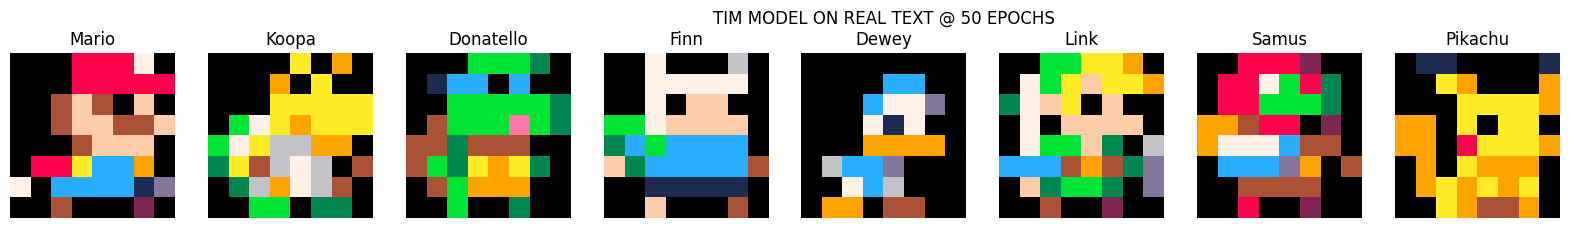

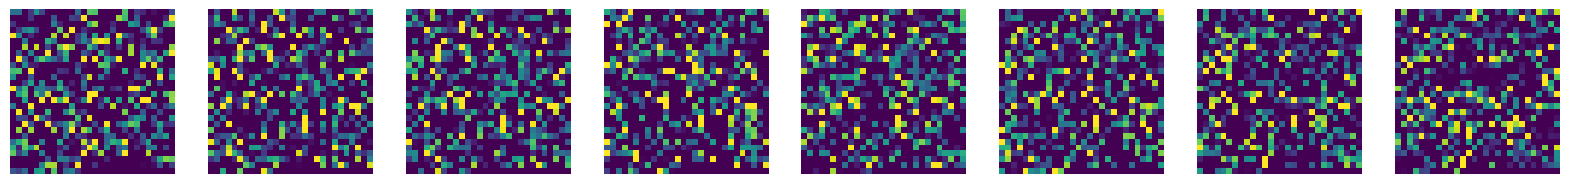

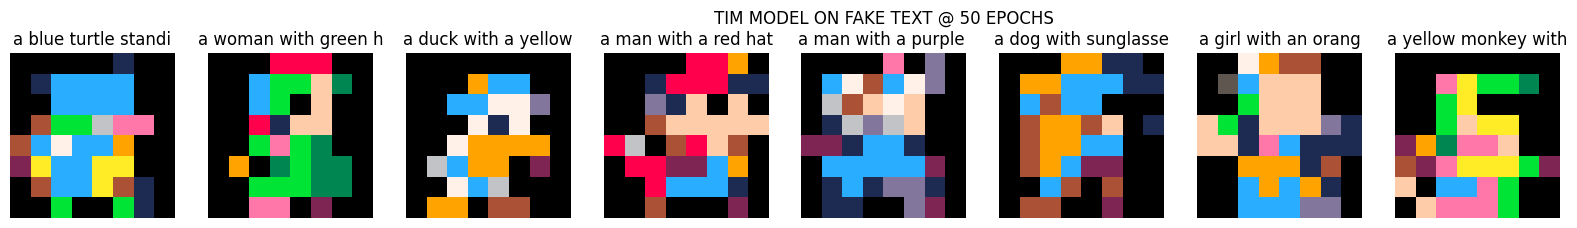

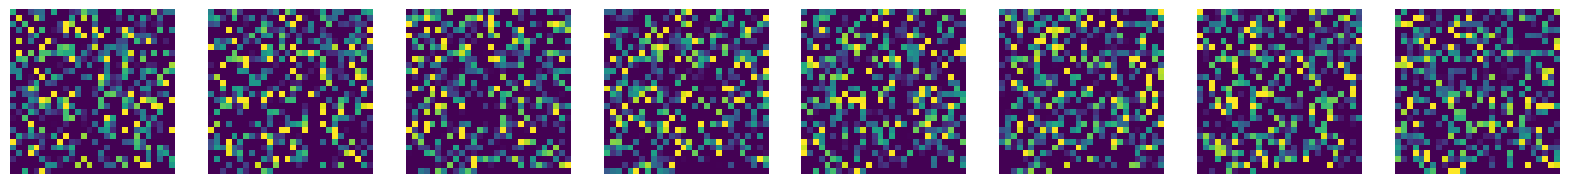

In [96]:
# see output with the embedding below
if EXPERIMENT == "clip":
    for k,m in clip_model_set.items():
        for t in ['real', 'fake']:
            testModel(m, clip_mod_test_set[t]['text'], clip_mod_test_set[t]['emb'], title=f"{k} model on {t} text @ {GEN_CONF['EPOCHS']} epochs", showEmb=True)

### Experiment 2 - Additive Noise Text Embedding

NOTES
- Milk Model able to get 100% accuracy in 50 epochs with noise; Tim model also converges extremely fast at 10 epochs
- Reconstruction great - fake data is garbage; on Tim model, it takes too much from the original training set


In [114]:
# make the models according to the experiment config
if EXPERIMENT == "add_noise":
    X_train_anoise = []
    Y_train_anoise = []

    con = CONFIGS["add_noise"]

    # noise variation of the training data
    for i in (range(len(pico_char_emb))):
        e = pico_char_emb[i]

        # add original
        X_train_anoise.append(e)
        Y_train_anoise.append(Y_train[i])

        # add additive noise
        for n in range(con["num_noise"]):
            en = e + np.random.normal(con['noise_mu'],con['noise_std'],e.shape)
            X_train_anoise.append(en)
            Y_train_anoise.append(Y_train[i])
            
    # back to numpy arrays
    X_train_anoise = np.array(X_train_anoise)
    Y_train_anoise = np.array(Y_train_anoise)

    print(f"X_train_anoise shape: {X_train_anoise.shape}")
    print(f"Y_train_anoise shape: {Y_train_anoise.shape}")

    
    # real texts to test the model on (keep the same without noise)
    add_noise_mod_test_set = {
        'real': {'text':mod_test_set['real']['text'][:], 'emb':mod_test_set['real']['emb'][:]},
        'fake': {'text':mod_test_set['fake']['text'][:], 'emb':mod_test_set['fake']['emb'][:]}
    }


X_train_anoise shape: (1100, 768)
Y_train_anoise shape: (1100, 8, 8, 16)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 256)               196864    
                                                                 
 reshape_31 (Reshape)        (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_32 (Conv2D  (None, 4, 4, 32)         8224      
 Transpose)                                                      
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 8, 8, 16)         2064      
 Transpose)                                                      
                                                                 
Total params: 207,152
Trainable params: 207,152
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
______________________________

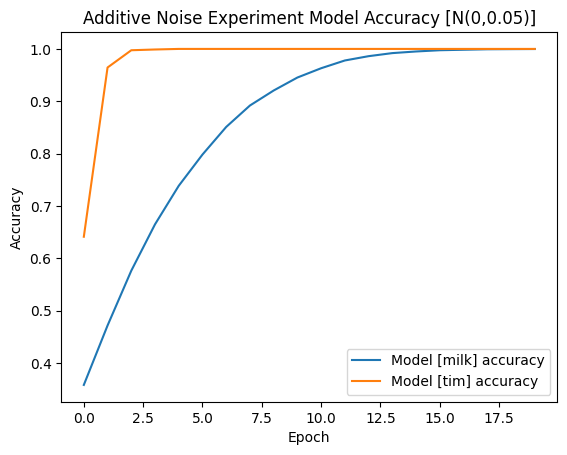

In [115]:
if EXPERIMENT == "add_noise":
    # make the models
    add_noise_model_set = {}
    for m in CONFIGS["add_noise"]["model_test"]:
        add_noise_model_set[m] = (FiveDollarModel(lv_shape=768,model_version=m,lr=GEN_CONF["LEARNING_RATE"]))
    
    # train the models or import them
    for k,m in add_noise_model_set.items():
        mod_path = CONFIGS["add_noise"]["model_path"].replace("#",k)

        # train from scratch
        if CONFIGS["add_noise"]["train_model"]:
            print(f"Training model {k}")
            acc = m.decoder.fit(X_train_anoise,Y_train_anoise,epochs=GEN_CONF["EPOCHS"],batch_size=GEN_CONF["BATCH_SIZE"], shuffle=True)

            # plot the accuracy
            plt.plot(acc.history['accuracy'], label=f'Model [{k}] accuracy') 

            # export the model
            if CONFIGS["add_noise"]["save_model"]:
                print(f"Saving model {k} to {mod_path}")
                m.exportModel(mod_path)

        # import the models
        else:
            print(f"Skipping training for model {k} and loading from {mod_path}")
            m.importModel(mod_path)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(f"Additive Noise Experiment Model Accuracy [N({CONFIGS['add_noise']['noise_mu']},{CONFIGS['add_noise']['noise_std']})]")
    plt.show()

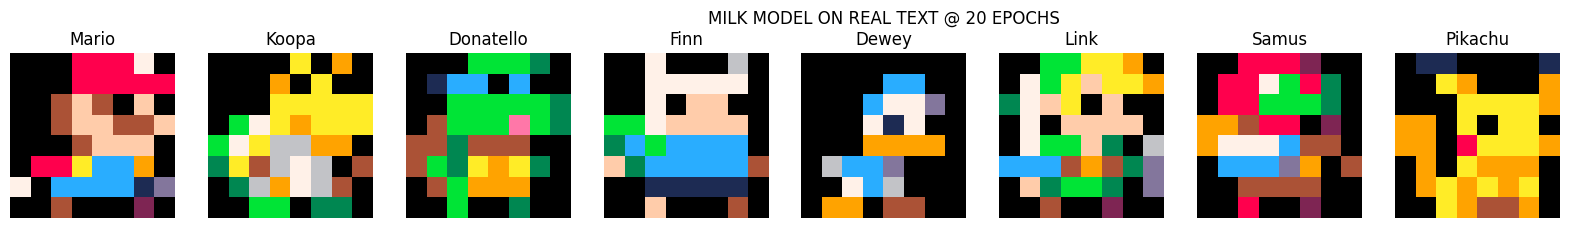

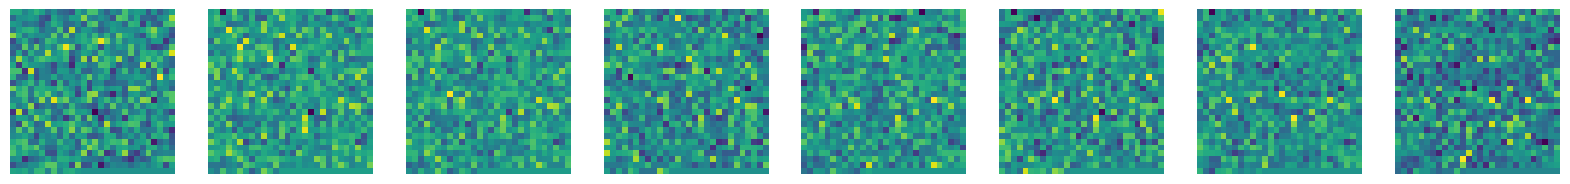

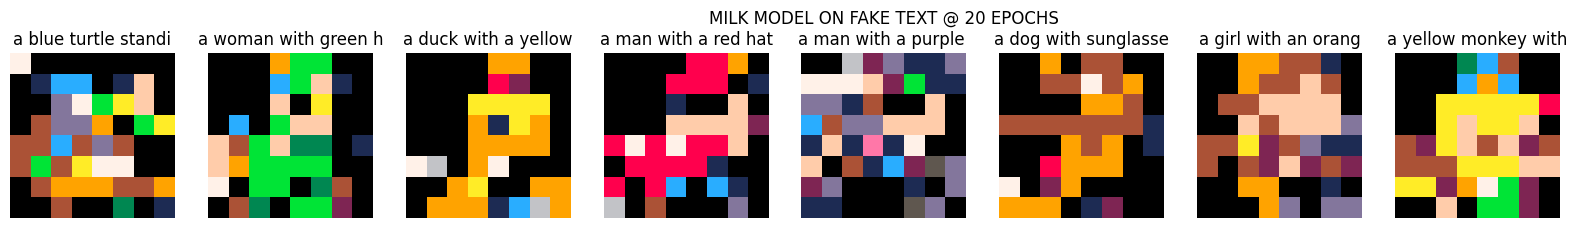

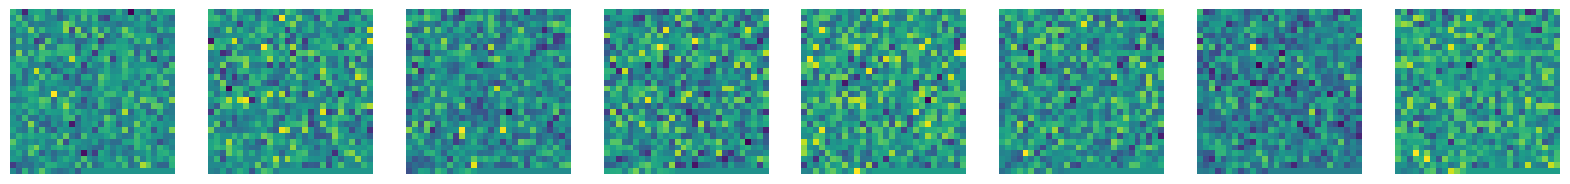

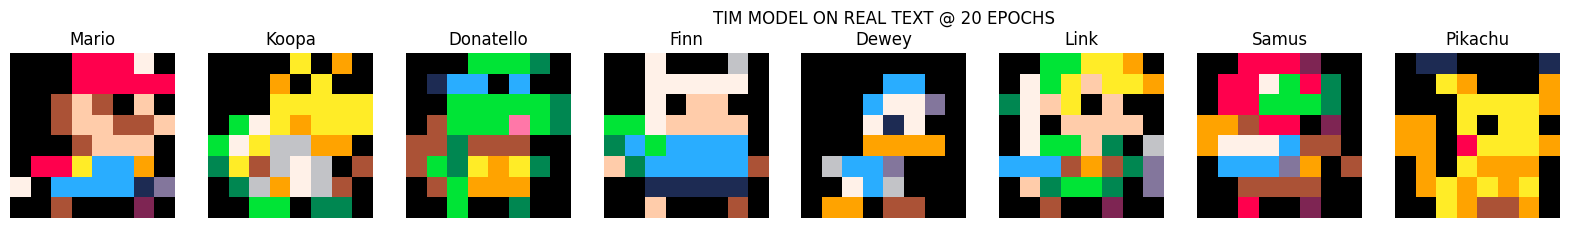

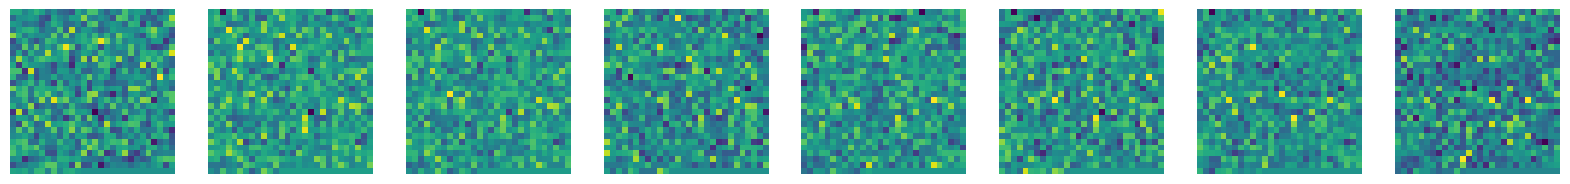

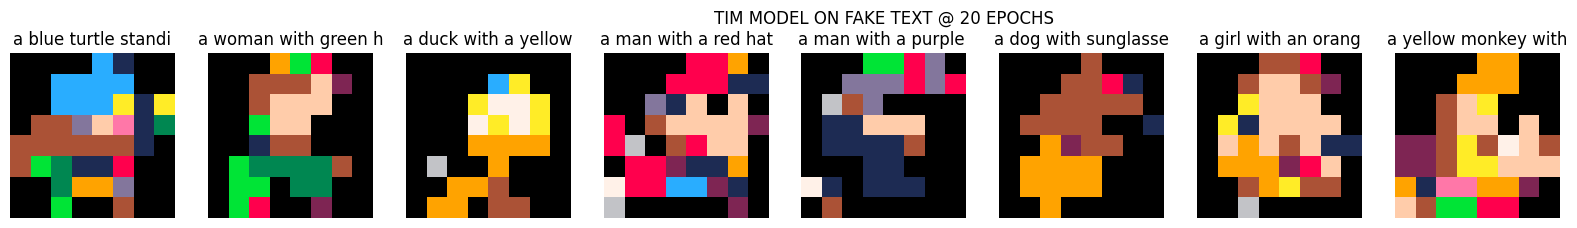

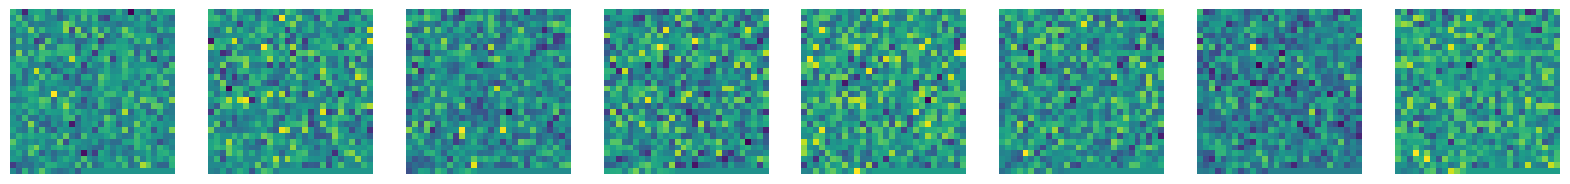

In [116]:
# see output with the embedding below
if EXPERIMENT == "add_noise":
    for k,m in add_noise_model_set.items():
        for t in ['real', 'fake']:
            testModel(m, add_noise_mod_test_set[t]['text'], add_noise_mod_test_set[t]['emb'], title=f"{k} model on {t} text @ {GEN_CONF['EPOCHS']} epochs", showEmb=True)

### Experiment 3 - Multiplicative Noise Text Embedding

NOTES

In [14]:
# make the models according to the experiment config
if EXPERIMENT == "mult_noise":
    X_train_mnoise = []
    Y_train_mnoise = []

    con = CONFIGS["mult_noise"]

    # noise variation of the training data
    for i in (range(len(pico_char_emb))):
        e = pico_char_emb[i]

        # add original
        X_train_mnoise.append(e)
        Y_train_mnoise.append(Y_train[i])

        # use multiplicative noise
        for n in range(con["num_noise"]):
            en = e * np.random.normal(con['noise_mu'],con['noise_std'],e.shape)
            X_train_mnoise.append(en)
            Y_train_mnoise.append(Y_train[i])
            
    # back to numpy arrays
    X_train_mnoise = np.array(X_train_mnoise)
    Y_train_mnoise = np.array(Y_train_mnoise)

    print(f"X_train_mnoise shape: {X_train_mnoise.shape}")
    print(f"Y_train_mnoise shape: {Y_train_mnoise.shape}")

    
    # real texts to test the model on (keep the same without noise)
    mult_noise_mod_test_set = {
        'real': {'text':mod_test_set['real']['text'][:], 'emb':mod_test_set['real']['emb'][:]},
        'fake': {'text':mod_test_set['fake']['text'][:], 'emb':mod_test_set['fake']['emb'][:]}
    }


X_train_mnoise shape: (1100, 768)
Y_train_mnoise shape: (1100, 8, 8, 16)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               196864    
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 32)         8224      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 16)         2064      
 ranspose)                                                       
                                                                 
Total params: 207,152
Trainable params: 207,152
Non-trainable params: 0
_________________________________________________________________


2023-05-01 11:54:22.865415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 512)          393728      ['input_2[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 2, 2, 128)    0           ['dense_1[0][0]']                
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 4, 4, 128)    0           ['reshape_1[0][0]']              
                                                                                            

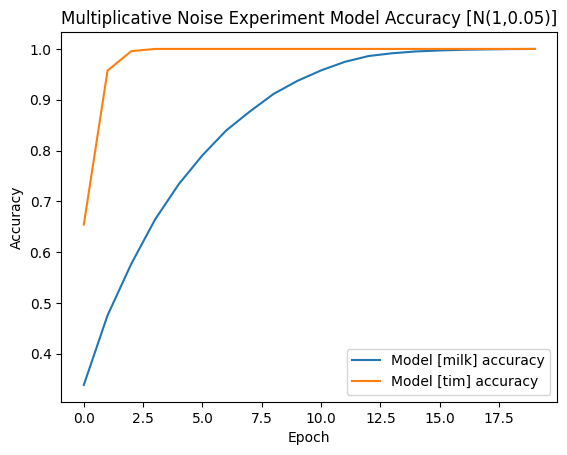

In [15]:
if EXPERIMENT == "mult_noise":
    # make the models
    mult_noise_model_set = {}
    for m in CONFIGS["mult_noise"]["model_test"]:
        mult_noise_model_set[m] = (FiveDollarModel(lv_shape=768,model_version=m,lr=GEN_CONF["LEARNING_RATE"]))
    
    # train the models or import them
    for k,m in mult_noise_model_set.items():
        mod_path = CONFIGS["mult_noise"]["model_path"].replace("#",k)

        # train from scratch
        if CONFIGS["mult_noise"]["train_model"]:
            print(f"Training model {k}")
            acc = m.decoder.fit(X_train_mnoise,Y_train_mnoise,epochs=GEN_CONF["EPOCHS"],batch_size=GEN_CONF["BATCH_SIZE"], shuffle=True)

            # plot the accuracy
            plt.plot(acc.history['accuracy'], label=f'Model [{k}] accuracy') 

            # export the model
            if CONFIGS["mult_noise"]["save_model"]:
                print(f"Saving model {k} to {mod_path}")
                m.exportModel(mod_path)

        # import the models
        else:
            print(f"Skipping training for model {k} and loading from {mod_path}")
            m.importModel(mod_path)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(f"Multiplicative Noise Experiment Model Accuracy [N({CONFIGS['mult_noise']['noise_mu']},{CONFIGS['mult_noise']['noise_std']})]")
    plt.show()

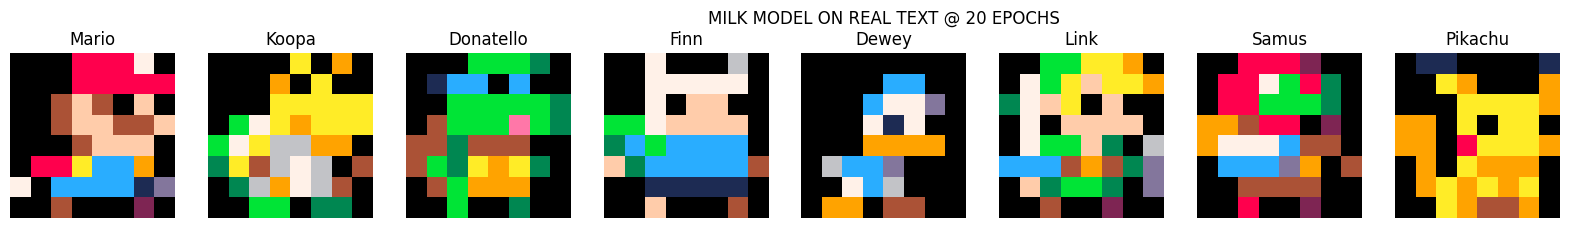

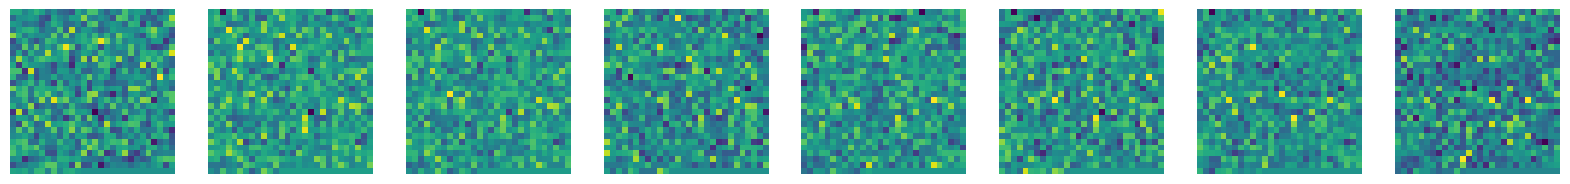

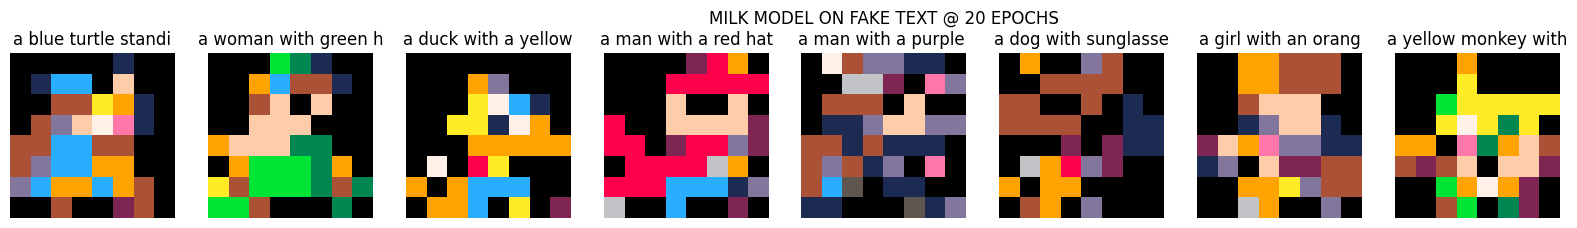

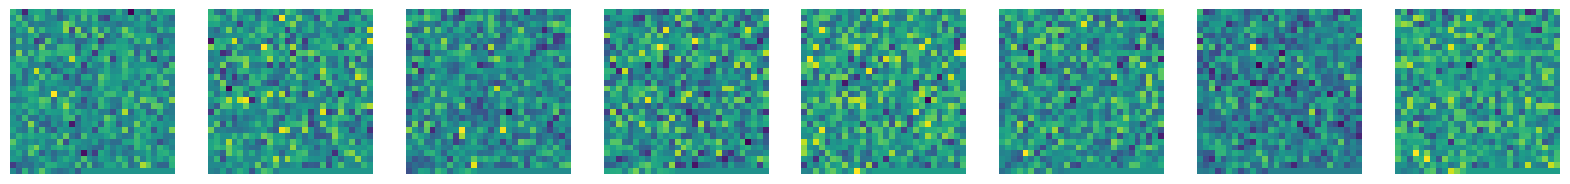

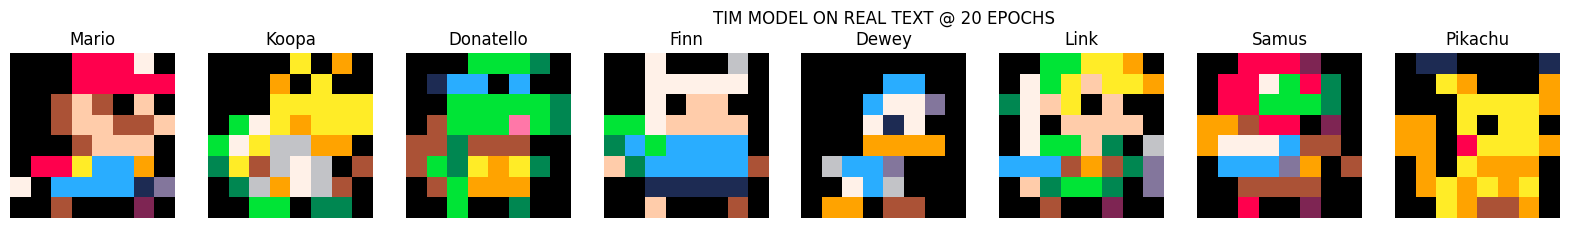

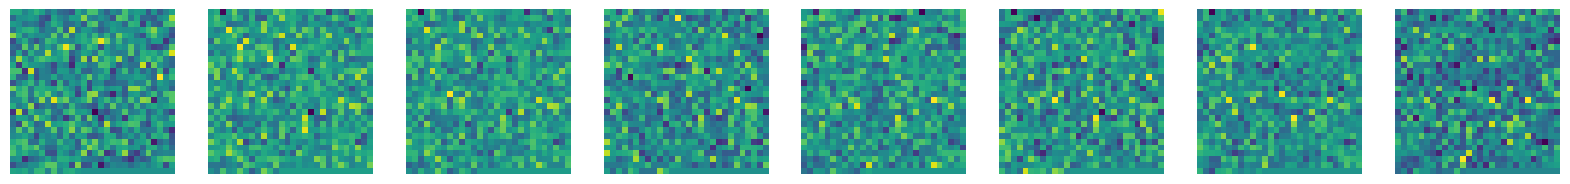

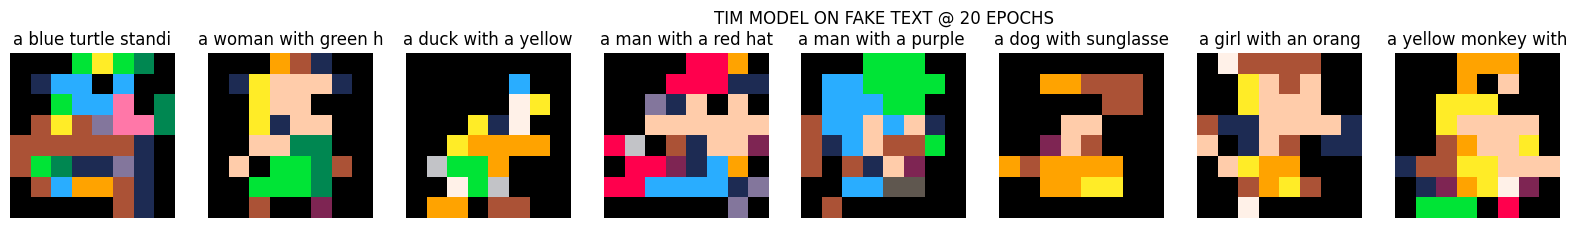

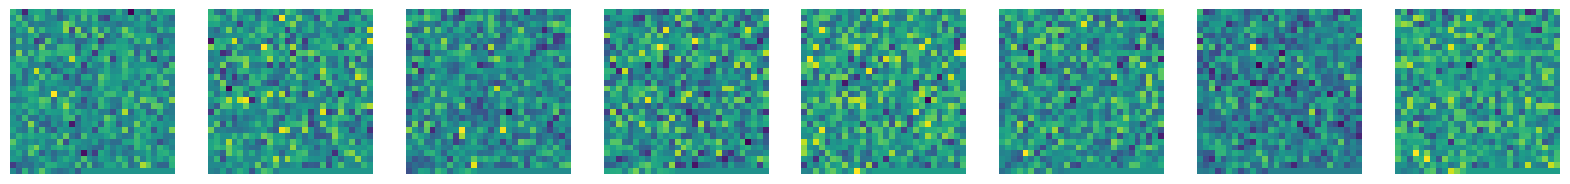

In [16]:
# see output with the embedding below
if EXPERIMENT == "mult_noise":
    for k,m in mult_noise_model_set.items():
        for t in ['real', 'fake']:
            testModel(m, mult_noise_mod_test_set[t]['text'], mult_noise_mod_test_set[t]['emb'], title=f"{k} model on {t} text @ {GEN_CONF['EPOCHS']} epochs", showEmb=True)